# Imports

In [339]:
import os
import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PolynomialKernel, PeriodicKernel, SpectralMixtureKernel, LinearKernel
from gpytorch.variational import CholeskyVariationalDistribution, LMCVariationalStrategy, VariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle

In [340]:
# Run id setup
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

date = '27-08-2024'
version = 'v2'
run_id = date + '_' + version

# Create a folder if it doesn't exist
folder_path = f'{run_id}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Cuda Initialization

In [341]:
cuda_available = torch.cuda.is_available()

device = torch.device('cuda' if cuda_available else 'cpu')

print(f'Using device: {device}')
if cuda_available:
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cuda
Number of GPUs available: 1
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1660 SUPER


# Dataset Creation and Loading

In [342]:
dataset = pd.read_csv('../Dataset/dataset.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Day'] = dataset['Date'].dt.day
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['Weekday'] = dataset['Date'].dt.weekday
dataset['Quarter'] = dataset['Date'].dt.quarter
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['Hour'] = dataset['Date'].dt.hour

dataset = dataset.sample(frac=0.01, random_state=42)

In [343]:
# target_vars = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']
target_vars = ['CO', 'NO2', 'NOX', 'O3', 'PM2.5']


X = dataset.drop(columns=['Date', 'Nombre_Estacion', 'Clave_Estacion'] + target_vars)  # Adjust columns as needed
y = dataset[target_vars]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Scale y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

batch_size = 2**10  # Adjust batch size as needed

pollution_dataset_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(pollution_dataset_train, batch_size=batch_size, shuffle=True)

print(X_train.device, y_train.device)
print(X_test.device, y_test.device)
print(batch_size)

torch.Size([1646, 19]) torch.Size([1646, 5])
torch.Size([412, 19]) torch.Size([412, 5])
cuda:0 cuda:0
cuda:0 cuda:0
1024


# Model Creation

In [344]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_latents, num_tasks, num_features):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, num_features, num_features).to(device)
        
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )
        
        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = LMCVariationalStrategy(
            VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = ConstantMean(batch_shape=torch.Size([num_latents]))

        self.covar_module = ScaleKernel(
            MaternKernel(nu=2.5, batch_shape=torch.Size([num_latents]), ard_num_dims=num_features), # + PeriodicKernel(batch_shape=torch.Size([num_latents]), ard_num_dims=num_features),
            batch_shape=torch.Size([num_latents])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [345]:
# Num_latents: Number of latent functions. A latent function is a function that is not directly observed but inferred through the observed data.
# Num_tasks: Number of tasks. In this case, the number of tasks is the number of output dimensions in the dataset.

# How to know how many latent functions to use? The number of latent functions is a hyperparameter that you can tune.
num_latents = 25
num_tasks = y.shape[-1]
num_features = X.shape[-1]
n_epochs = 1000

model = MultitaskGPModel(num_latents, num_tasks, num_features).to(device)
likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

In [346]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0)).to(device)

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs = tqdm(range(n_epochs), desc="Epoch")
for epoch in epochs:
    for X_batch, y_batch in train_loader:
        # print(X_batch.shape, y_batch.shape)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

# Save the Model

In [347]:
# Save the model parameters
with open(f'{run_id}/{run_id}_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open(f'{run_id}/{run_id}_likelihood.pkl', 'wb') as file:
    pickle.dump(likelihood, file)

# Load the Model

In [348]:
with open(f'{run_id}/{run_id}_model.pkl', 'rb') as file:
    model = pickle.load(file)

with open(f'{run_id}/{run_id}_likelihood.pkl', 'rb') as file:
    likelihood = pickle.load(file)

In [349]:
y_pred = likelihood(model(X_test))
y_pred = y_pred.mean
y_pred = y_pred.cpu().detach().numpy()

y_pred_np = scaler_y.inverse_transform(y_pred)
y_test_np = scaler_y.inverse_transform(y_test.cpu().detach().numpy())

In [350]:
r2 = r2_score(y_pred=y_pred_np, y_true=y_test_np, multioutput='raw_values')
mae = mean_absolute_error(y_pred=y_pred_np, y_true=y_test_np, multioutput='raw_values')
mse = mean_squared_error(y_pred=y_pred_np, y_true=y_test_np, multioutput='raw_values')
rmse = np.sqrt(mse)

results = pd.DataFrame({
    'R2': r2,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
}, index=target_vars)

results

,R2,MAE,MSE,RMSE
CO,0.669476,0.291187,0.137985,0.371464
NO2,0.639149,4.329083,53.308327,7.301255
NOX,0.927483,4.637040,63.244137,7.952618
O3,0.639579,7.768899,125.197372,11.189163
PM2.5,0.647339,7.816344,165.715286,12.873045


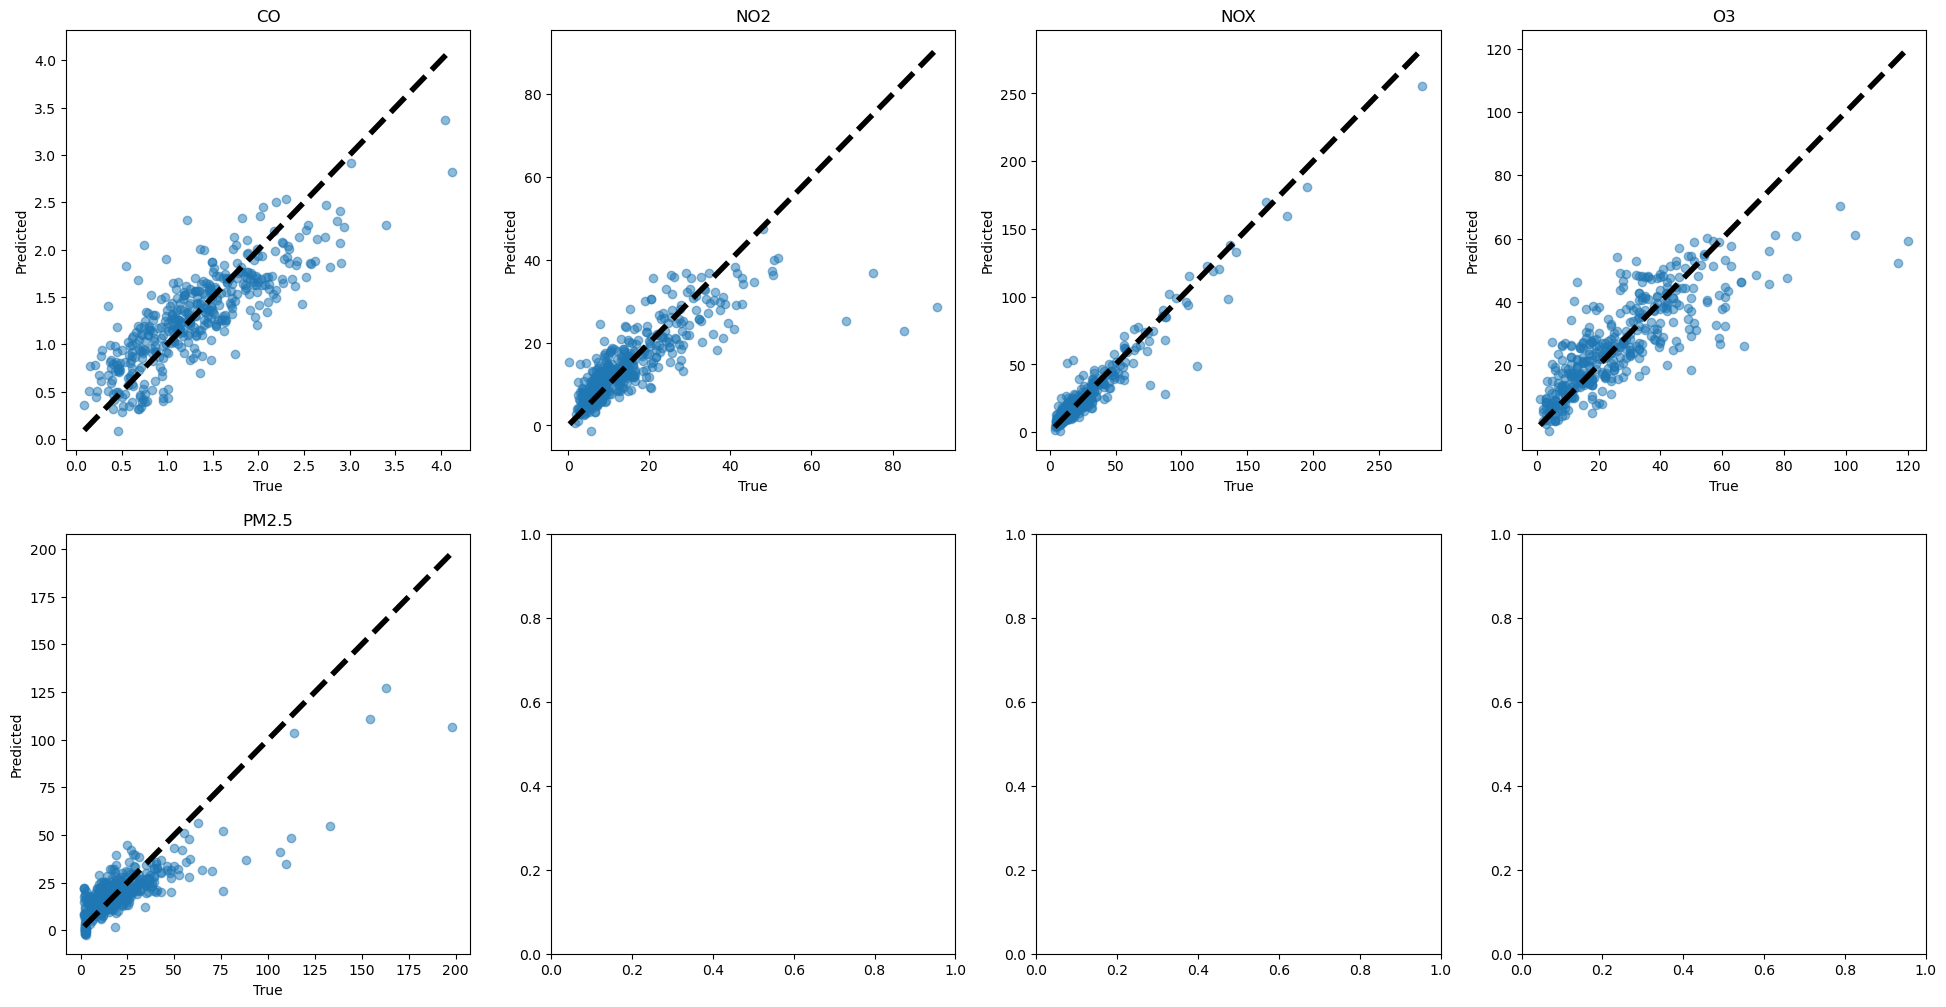

In [351]:
fig, axes = plt.subplots(2, 4, figsize=(6*4, 6*2))

axes = axes.flatten()

for i in range(len(target_vars)):
    ax = axes[i]
    ax.scatter(y_test_np[:, i], y_pred_np[:, i], alpha=0.5)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(target_vars[i])
    ax.plot([y_test_np[:, i].min(), y_test_np[:, i].max()], [y_test_np[:, i].min(), y_test_np[:, i].max()], 'k--', lw=4)

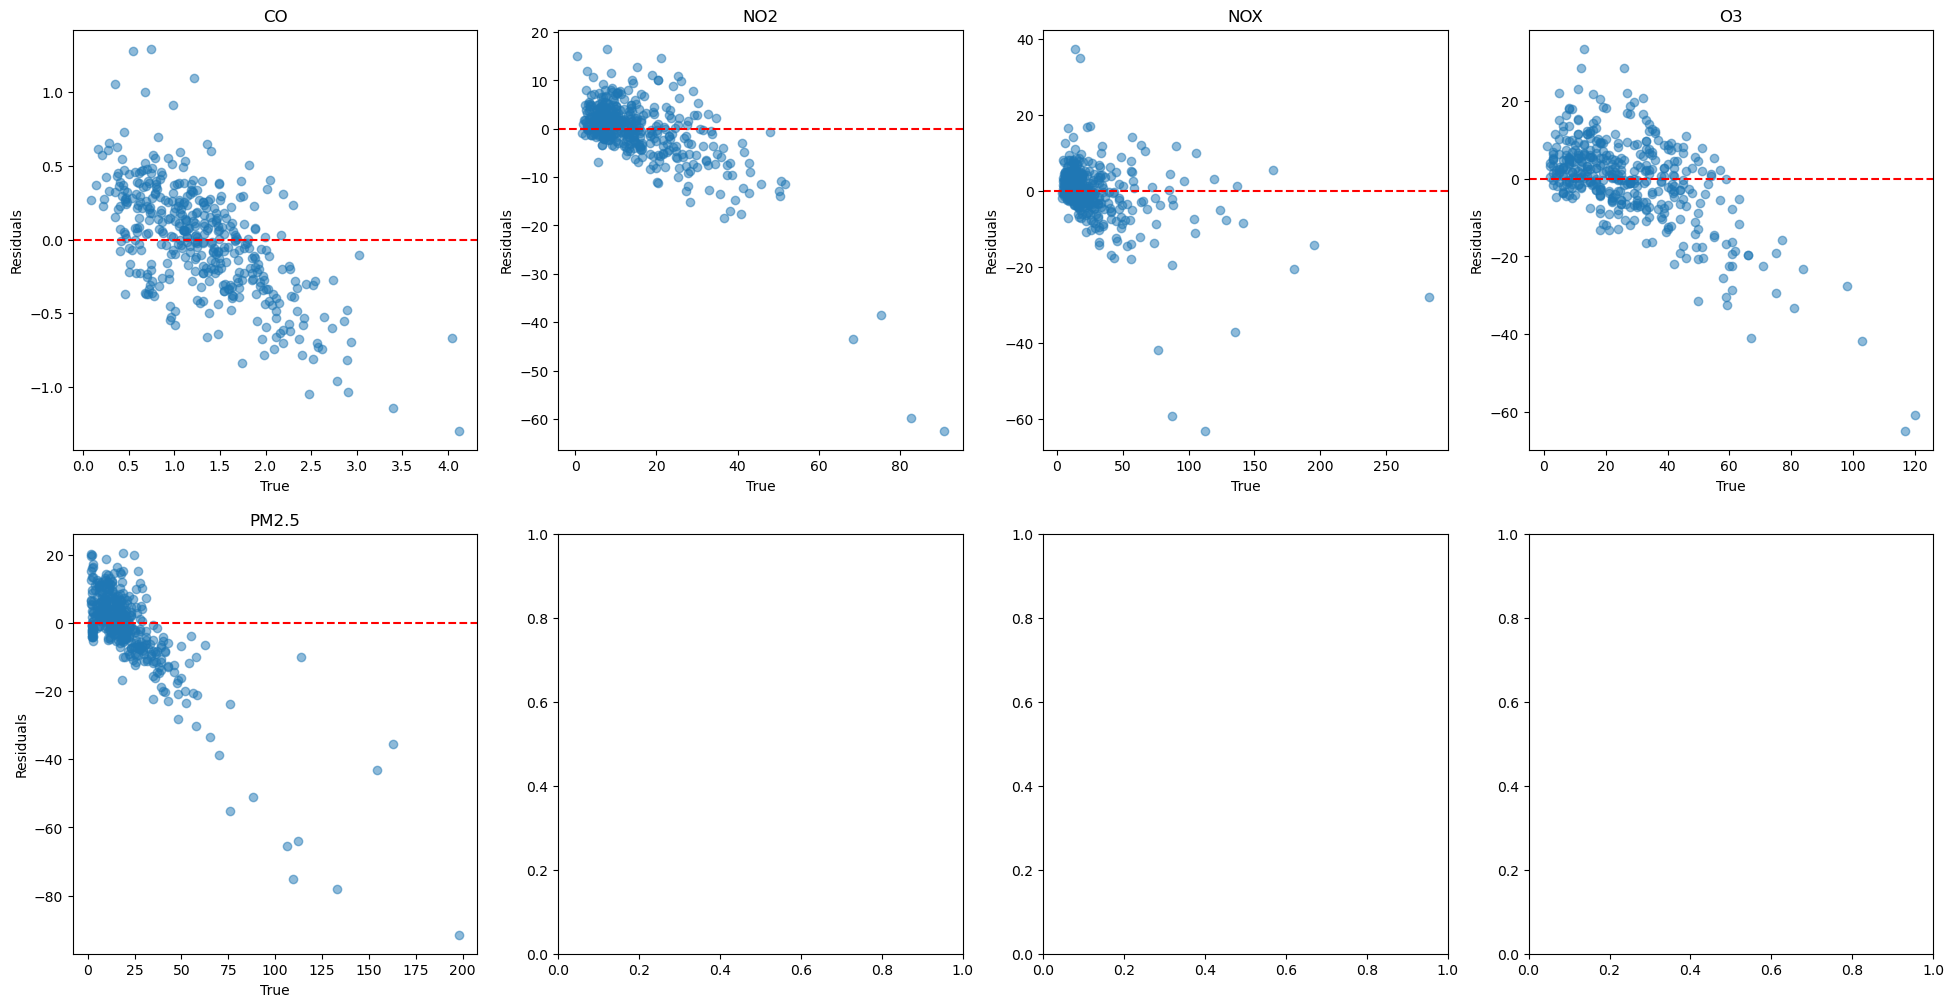

In [352]:
# plot residuals

fig, axes = plt.subplots(2, 4, figsize=(6*4, 6*2))

axes = axes.flatten()

for i in range(len(target_vars)):
    ax = axes[i]
    residuals = y_pred_np[:, i] - y_test_np[:, i]
    ax.scatter(y_test_np[:, i], residuals, alpha=0.5)
    ax.set_xlabel('True')
    ax.set_ylabel('Residuals')
    ax.set_title(target_vars[i])
    ax.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0

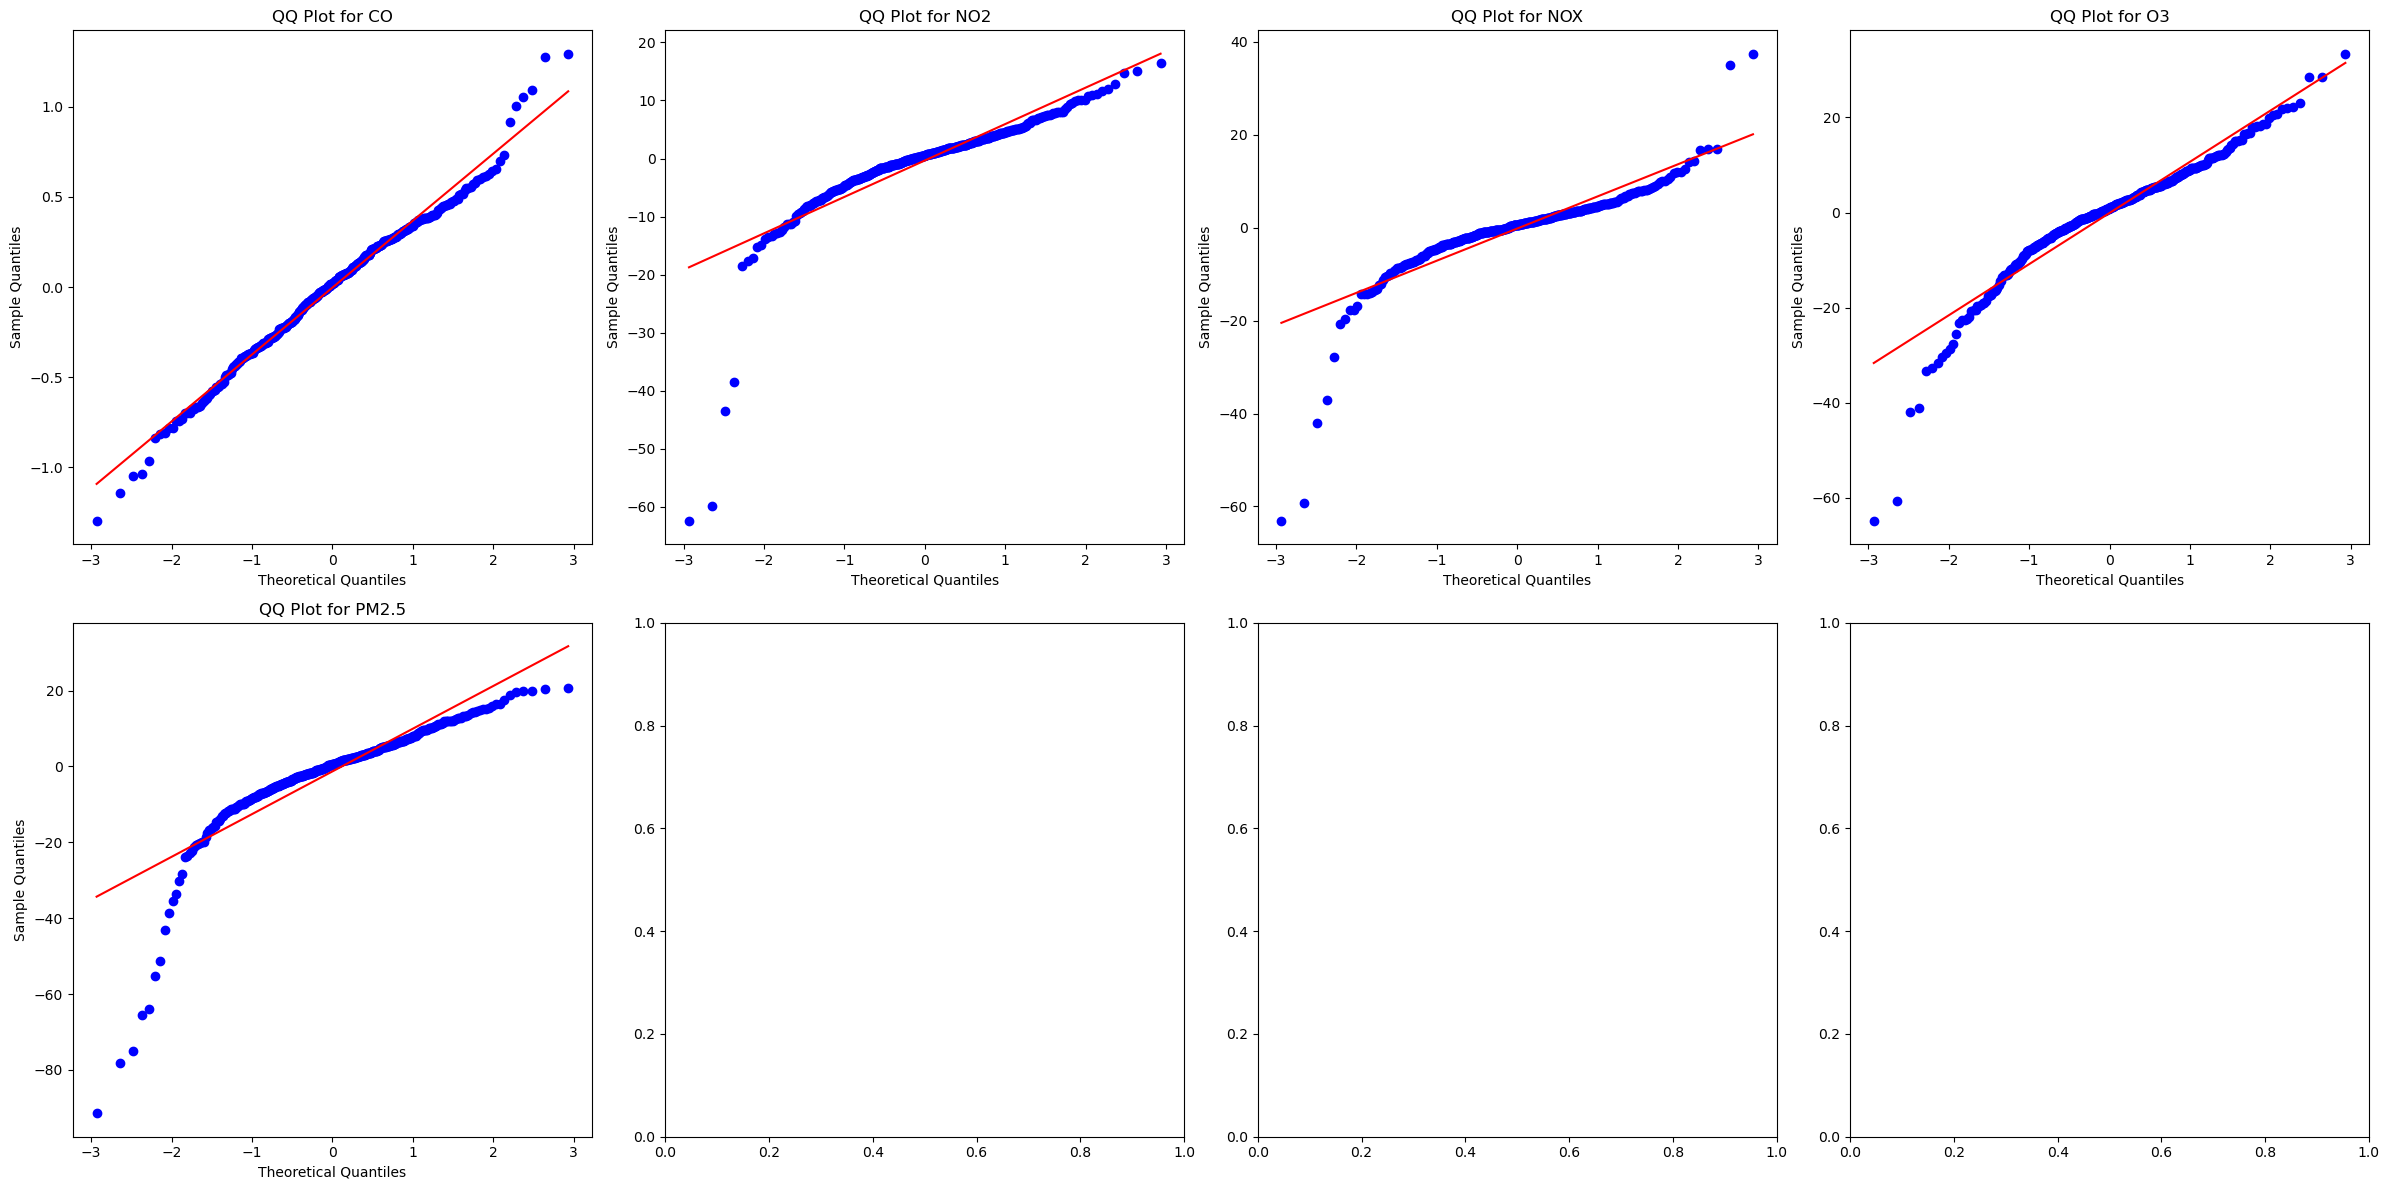

In [353]:

import scipy.stats as stats
fig, axes = plt.subplots(2, 4, figsize=(6*4, 6*2))

axes = axes.flatten()

for i in range(len(target_vars)):
    residuals = y_pred_np[:, i] - y_test_np[:, i]
    stats.probplot(residuals, dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ Plot for {target_vars[i]}')
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

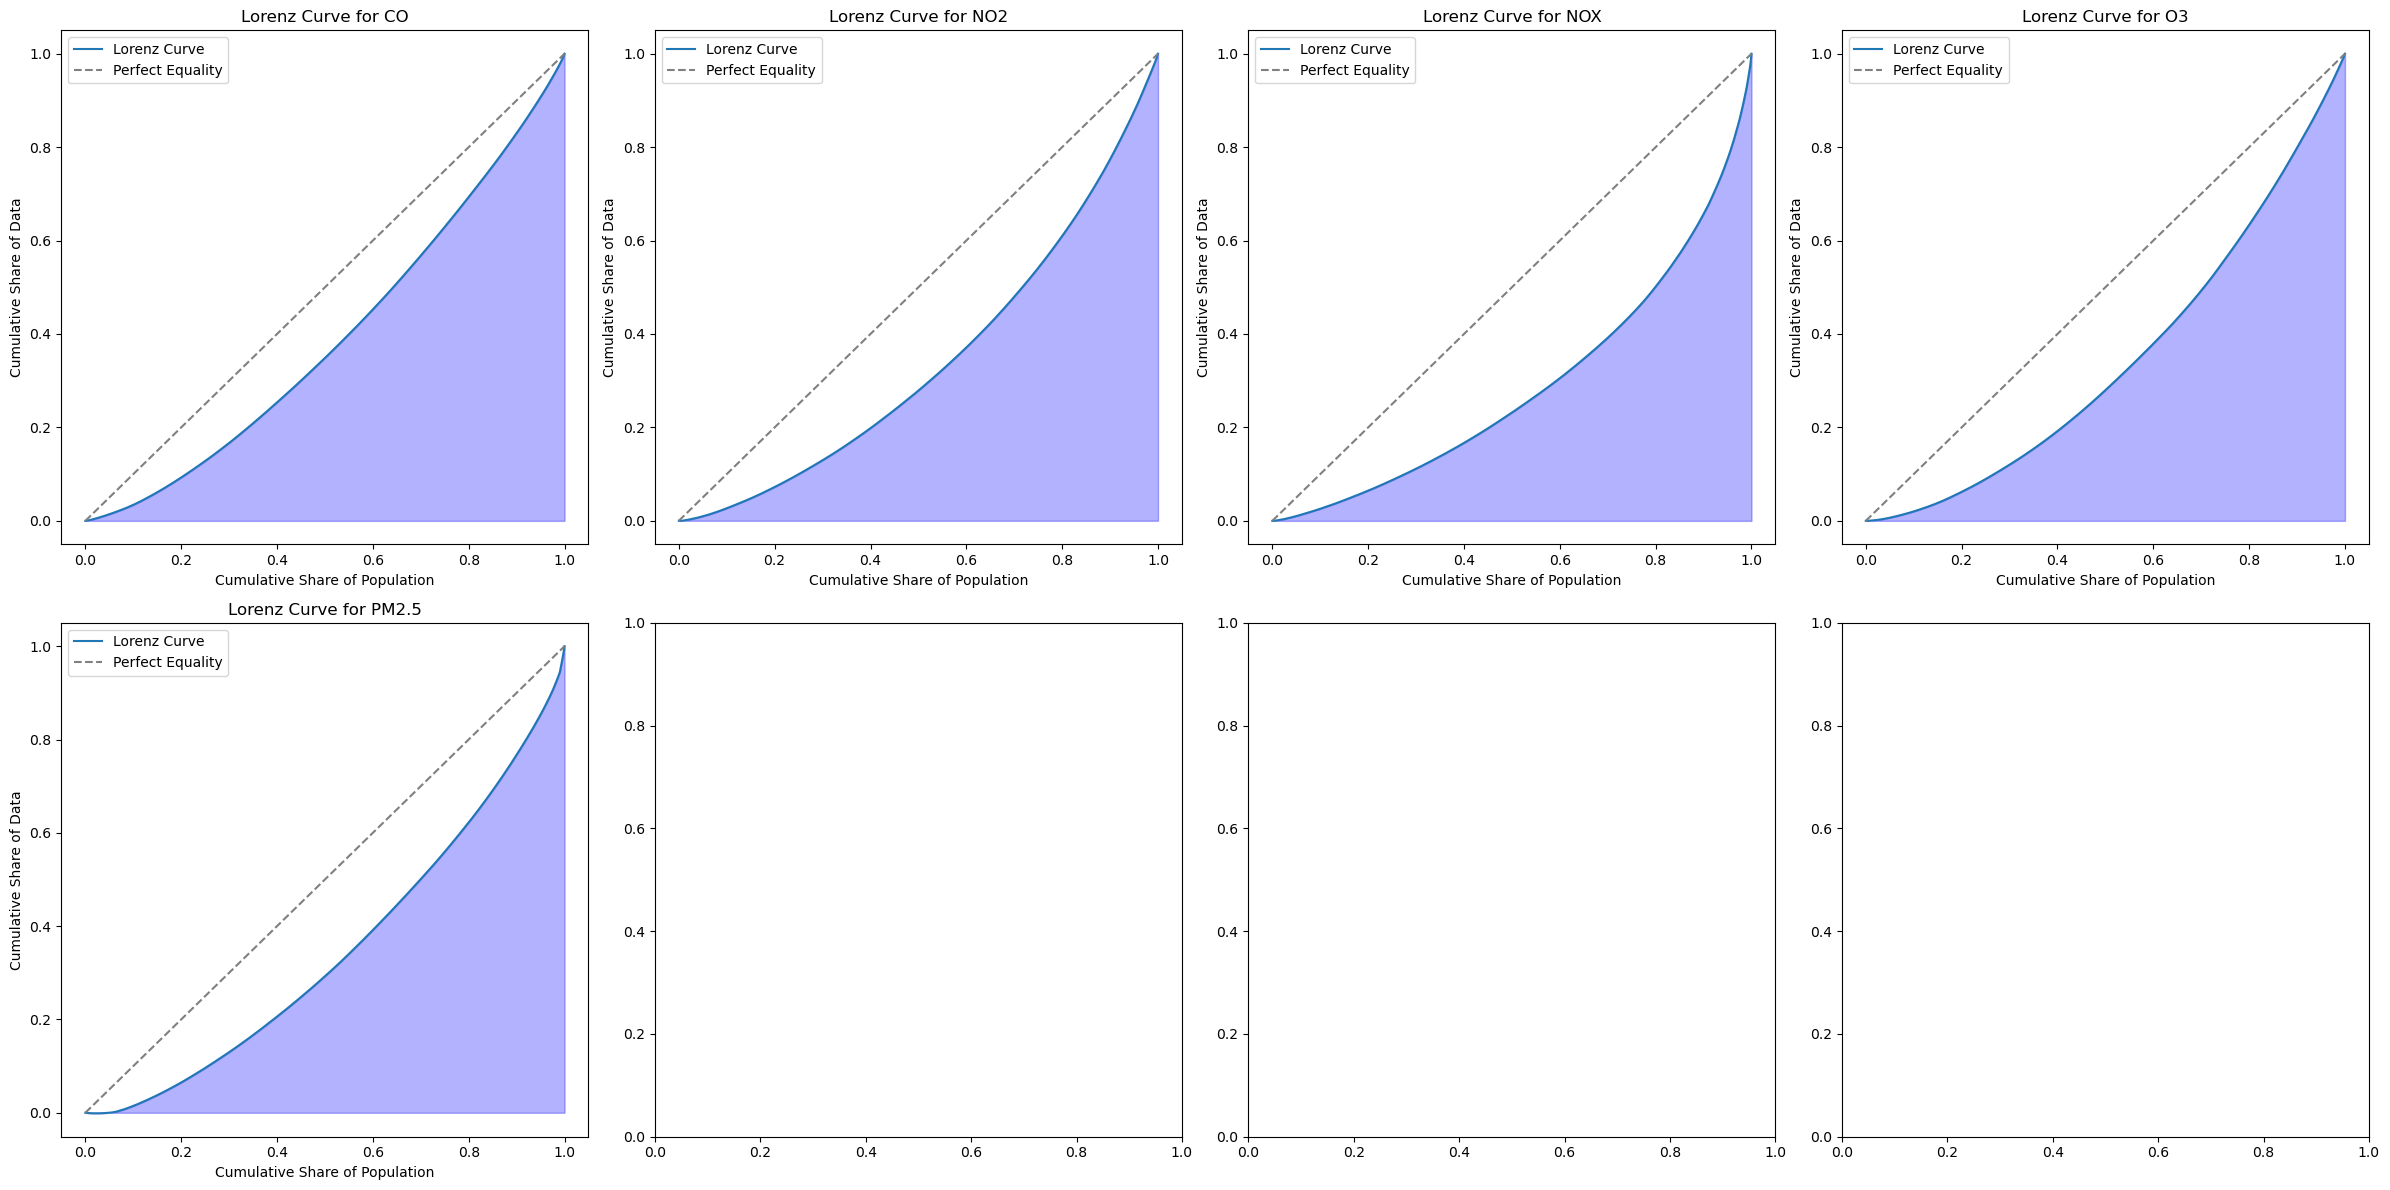

In [354]:
fig, axes = plt.subplots(2, 4, figsize=(6*4, 6*2))

axes = axes.flatten()

for i in range(len(target_vars)):
    y_pred_ordered = np.sort(y_pred_np[:, i])
    y_pred_ordered = np.insert(y_pred_ordered, 0, 0)
    y_pred_lorenz = np.cumsum(y_pred_ordered) / np.sum(y_pred_ordered)

    x_vals = np.linspace(0, 1, len(y_pred_lorenz))
    
    axes[i].plot(x_vals, y_pred_lorenz, label='Lorenz Curve')
    axes[i].fill_between(x_vals, 0, y_pred_lorenz, alpha=0.3, color='blue')  # Fill under the Lorenz Curve
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Equality')
    axes[i].set_xlabel('Cumulative Share of Population')
    axes[i].set_ylabel('Cumulative Share of Data')
    axes[i].set_title(f'Lorenz Curve for {target_vars[i]}')
    axes[i].legend()

plt.tight_layout()
plt.show()